# **INSIDER THREAT USING TRANSFORMERS ON USER ACTIVITY LOGS**

**Topik Riset:**

"Deteksi Ancaman Internal Menggunakan Transformer untuk Menganalisis Log Aktivitas Pengguna"

**Deskripsi:**

Transformer digunakan untuk menganalisis aktivitas pengguna secara menyeluruh. Model ini dilatih untuk mendeteksi pola akses yang tidak biasa oleh pengguna internal, seperti akses data di luar jam kerja atau aktivitas mencurigakan lainnya, dengan mempelajari urutan akses file dan sistem.

**Novelty:**

Sedang hingga tinggi. Insider threat sudah menjadi fokus penelitian dengan berbagai metode deteksi perilaku anomali. Namun, Transformer, dengan kemampuannya untuk menangkap perubahan perilaku yang halus dalam urutan log, menawarkan pendekatan baru yang dapat meningkatkan performa deteksi.


**Dataset: CERT Insider threat**

Dataset ini berisi data aktivitas pengguna yang mencurigakan dan bisa digunakan untuk mendeteksi Insider Threat. Model Transformer bisa mengenali pola akses yang anomali berdasarkan log pengguna.

URL: https://www.kaggle.com/datasets/nitishabharathi/cert-insider-threat


# **Importing Modules and Libraries**

In [1]:
!pip install numpy pandas seaborn matplotlib scikit-learn

In [2]:
!pip list | findstr numpy

/bin/bash: line 1: findstr: command not found
ERROR: Pipe to stdout was broken
Exception ignored in: <_io.TextIOWrapper name='<stdout>' mode='w' encoding='utf-8'>
BrokenPipeError: [Errno 32] Broken pipe


In [3]:
!pip install torch torchvision torchaudio

In [1]:
# importing required libraries
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import pickle
from os import path

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn import metrics
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

# **Importing Datasets**

In [2]:
import pandas as pd

Data = pd.read_csv('email.csv')

In [3]:
Data.head(n=5)

,id,date,user,pc,to,cc,bcc,from,size,attachments,content
0,{R3I7-S4TX96FG-8219JWFF},01/02/2010 07:11:45,LAP0338,PC-5758,Dean.Flynn.Hines@dtaa.com;Wade_Harrison@lockhe...,Nathaniel.Hunter.Heath@dtaa.com,NaN,Lynn.Adena.Pratt@dtaa.com,25830,0,middle f2 systems 4 july techniques powerful d...
1,{R0R9-E4GL59IK-2907OSWJ},01/02/2010 07:12:16,MOH0273,PC-6699,Odonnell-Gage@bellsouth.net,NaN,NaN,MOH68@optonline.net,29942,0,the breaking called allied reservations former...
2,{G2B2-A8XY58CP-2847ZJZL},01/02/2010 07:13:00,LAP0338,PC-5758,Penelope_Colon@netzero.com,NaN,NaN,Lynn_A_Pratt@earthlink.net,28780,0,slowly this uncinus winter beneath addition ex...
3,{A3A9-F4TH89AA-8318GFGK},01/02/2010 07:13:17,LAP0338,PC-5758,Judith_Hayden@comcast.net,NaN,NaN,Lynn_A_Pratt@earthlink.net,21907,0,400 other difficult land cirrocumulus powered ...
4,{E8B7-C8FZ88UF-2946RUQQ},01/02/2010 07:13:28,MOH0273,PC-6699,Bond-Raymond@verizon.net;Alea_Ferrell@msn.com;...,NaN,Odonnell-Gage@bellsouth.net,MOH68@optonline.net,17319,0,this kmh october holliswood number advised unu...


In [4]:
data = Data.sample(frac=0.02, random_state=42)

In [5]:
data.isnull().sum()

id                 0
date               0
user               0
pc                 0
to                 0
cc             32565
bcc            44328
from               0
size               0
attachments        0
content            0
dtype: int64

In [6]:
# Cek dan isi nilai hilang
data.fillna(0, inplace=True)  # Mengisi nilai hilang dengan 0
#data = data.dropna()

In [7]:
data.isnull().sum()

id             0
date           0
user           0
pc             0
to             0
cc             0
bcc            0
from           0
size           0
attachments    0
content        0
dtype: int64

In [8]:
# Threshold ukuran (25KB)
size_threshold = 25000

# Fungsi untuk menentukan aktivitas di luar jam kerja
def is_after_hours(date_str):
    hour = pd.to_datetime(date_str).hour  # Ekstrak jam dari 'date'
    return hour < 8 or hour > 18  # Jam kerja dianggap antara 08:00 - 18:00

# Membuat label (1 = mencurigakan, 0 = normal)
data['label'] = data.apply(lambda x:
    1 if x['size'] > size_threshold or is_after_hours(x['date']) else 0, axis=1)

# Cek hasil labeling
print(data[['user', 'date', 'size', 'label']].head())


            user                 date   size  label
1375085  HWH0646  09/08/2010 09:48:21  53433      1
1760687  EMW0772  11/18/2010 11:40:48  23746      0
489761   HAD0246  03/29/2010 14:40:35  20984      0
670295   ASB0796  04/30/2010 10:57:44  33996      1
2611719  HCW0419  05/12/2011 11:45:23  37670      1


In [9]:
# Misalkan kolom yang berisi label adalah 'type'
# Menampilkan nilai unik dan jumlah setiap kelas
kelas = data['label'].value_counts()
print(kelas)

# Menampilkan jumlah kelas unik
jumlah_kelas = data['label'].nunique()
print(f"Jumlah kelas unik: {jumlah_kelas}")


label
1    35281
0    17319
Name: count, dtype: int64
Jumlah kelas unik: 2


In [10]:
features = ['size', 'attachments', 'user', 'to', 'from', 'content']

In [11]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer

X = data[features]  # Fitur
y = data['label']   # Target label

# Pisahkan fitur numerik dan teks
numeric_features = ['size', 'attachments', 'user', 'to', 'from']
text_feature = ['content']


# Label encode untuk kolom yang berupa kategori
label_encoder = LabelEncoder()
data['user'] = label_encoder.fit_transform(data['user'])
data['to'] = label_encoder.fit_transform(data['to'])
data['from'] = label_encoder.fit_transform(data['from'])

# TF-IDF untuk mengonversi 'content' menjadi representasi vektor
tfidf_vectorizer = TfidfVectorizer(max_features=1000) 
X_content_tfidf = tfidf_vectorizer.fit_transform(data['content']).toarray()  # Mengubah kolom 'content' menjadi vektor

# Pisahkan fitur numerik dan teks dalam X
X_numeric = data[numeric_features]
X_text = pd.DataFrame(X_content_tfidf)

# Gabungkan fitur numerik dengan fitur teks setelah TF-IDF
X_combined = pd.concat([X_numeric, X_text], axis=1)

X_combined = X_combined.fillna(X_combined.median())

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52600 entries, 1375085 to 2049455
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           52600 non-null  object
 1   date         52600 non-null  object
 2   user         52600 non-null  int64 
 3   pc           52600 non-null  object
 4   to           52600 non-null  int64 
 5   cc           52600 non-null  object
 6   bcc          52600 non-null  object
 7   from         52600 non-null  int64 
 8   size         52600 non-null  int64 
 9   attachments  52600 non-null  int64 
 10  content      52600 non-null  object
 11  label        52600 non-null  int64 
dtypes: int64(6), object(6)
memory usage: 7.2+ MB


# **Data Visualization**

In [12]:
print(data.columns)

Index(['id', 'date', 'user', 'pc', 'to', 'cc', 'bcc', 'from', 'size',
       'attachments', 'content', 'label'],
      dtype='object')


In [13]:
print(data['label'].value_counts())

label
1    35281
0    17319
Name: count, dtype: int64


Jumlah kelas unik: 2


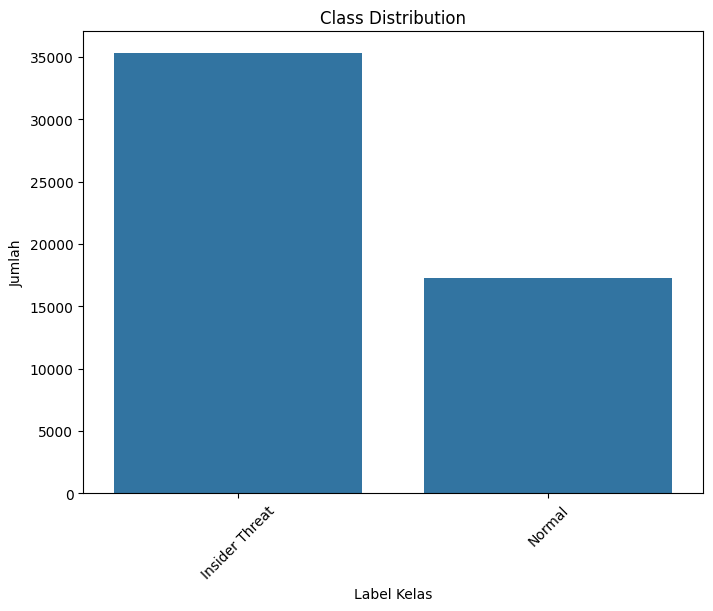

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Misalkan Anda telah menyiapkan DataFrame data
# Gantilah 'label' dengan nilai string sesuai label Anda
data['label'] = data['label'].replace({
    0: "Normal",
    1: "Insider Threat",
})

# Hitung jumlah kelas unik
jumlah_kelas = data['label'].nunique()
print(f"Jumlah kelas unik: {jumlah_kelas}")

# Visualisasi distribusi kelas dengan nama
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=data)
plt.title('Class Distribution')
plt.xlabel('Label Kelas')
plt.ylabel('Jumlah')
plt.xticks(rotation=45)  # Memutar label sumbu x jika perlu
plt.show()


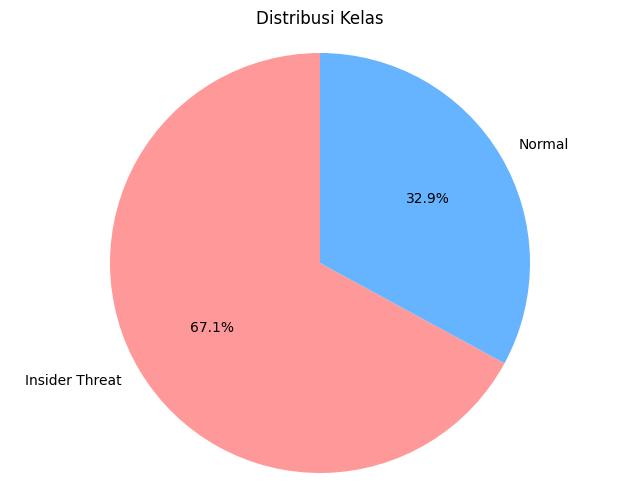

In [15]:
# Hitung jumlah setiap kelas
kelas_count = data['label'].value_counts()

# Buat pie chart
plt.figure(figsize=(8, 6))
plt.pie(kelas_count, labels=kelas_count.index, autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff','#99ff99'])
plt.axis('equal')  # Untuk membuat pie chart menjadi lingkaran
plt.title('Distribusi Kelas')
plt.show()


In [16]:
# Kembali ke format numerik
data['label'] = data['label'].replace({
    "Normal": 0,
    "Insider Threat": 1
}).astype(int)  # Pastikan kolom menjadi integer

# Pastikan nilai kembali ke format numerik
print(data['label'].value_counts())


label
1    35281
0    17319
Name: count, dtype: int64


C:\Users\User\AppData\Local\Temp\ipykernel_15024\4173804448.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['label'] = data['label'].replace({


# **Data Balancing**

In [13]:
# 1. Mengimpor Modul yang Diperlukan
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from os import path
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE

In [14]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer

# Data Anda
X = data[features]  # Fitur
y = data['label']   # Target label

# Pisahkan fitur numerik dan teks
numeric_features = ['size', 'attachments', 'user', 'to', 'from']
text_feature = ['content']

# Label encode untuk fitur kategori
label_encoder = LabelEncoder()
data['user'] = label_encoder.fit_transform(data['user'])
data['to'] = label_encoder.fit_transform(data['to'])
data['from'] = label_encoder.fit_transform(data['from'])

# TF-IDF untuk mengonversi 'content' menjadi representasi vektor
tfidf_vectorizer = TfidfVectorizer(max_features=1000)  # Mengurangi jumlah fitur untuk menghemat memori
X_content_tfidf = tfidf_vectorizer.fit_transform(data['content'])  # Menggunakan sparse matrix langsung

# Pisahkan fitur numerik dan teks dalam X
X_numeric = data[numeric_features]
X_text = pd.DataFrame(X_content_tfidf.toarray())  # Mengonversi sparse matrix ke DataFrame untuk proses lebih lanjut

# Gabungkan fitur numerik dengan fitur teks setelah TF-IDF
X_combined = pd.concat([X_numeric, X_text], axis=1)

X_combined = X_combined.fillna(X_combined.median())

# Scaling fitur numerik
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_combined[numeric_features])

# Sesuaikan jumlah baris antara X_scaled dan y (menggunakan slicing array numpy)
X_scaled = X_scaled[:len(y), :]  # Menyamakan jumlah baris pada X_scaled dengan y

# SMOTE untuk penyeimbangan kelas hanya pada fitur numerik
smote = SMOTE(sampling_strategy='auto', random_state=50)
X_resampled_numeric, y_resampled = smote.fit_resample(X_scaled, y)

# Gabungkan kembali data numerik yang telah di-resample dengan fitur teks yang tidak diubah
X_resampled_combined = pd.concat([pd.DataFrame(X_resampled_numeric), X_text], axis=1)

# Pisahkan data menjadi data latih dan uji
X_train, X_test, y_train, y_test = train_test_split(X_resampled_combined, y_resampled, test_size=0.2, random_state=42)

# Cek data yang sudah diproses
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

# Cek distribusi label setelah SMOTE
print(y_resampled.value_counts())


(56449, 1005) (56449,)
(14113, 1005) (14113,)
label
1    35281
0    35281
Name: count, dtype: int64


# **LIBRARY TRANSFORMER**

Instalasi Paket yang Diperlukan

Instalasi paket: Menginstal berbagai paket yang diperlukan untuk pembelajaran mesin dan pemrosesan data.

In [28]:
!pip install transformers tensorflow scikit-learn matplotlib pandas

In [29]:
!pip install transformers torch scikit-learn

In [21]:
pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


# **1. TRANSFORMER "ENCODER" + Dataset Bersih**

# **CLASSIFICATION**


Fold 1
Accuracy for fold 1: 96.46%
F1 Score for fold 1: 0.9645
              precision    recall  f1-score   support

           0       0.94      0.99      0.97      3554
           1       0.99      0.94      0.96      3503

    accuracy                           0.96      7057
   macro avg       0.97      0.96      0.96      7057
weighted avg       0.97      0.96      0.96      7057



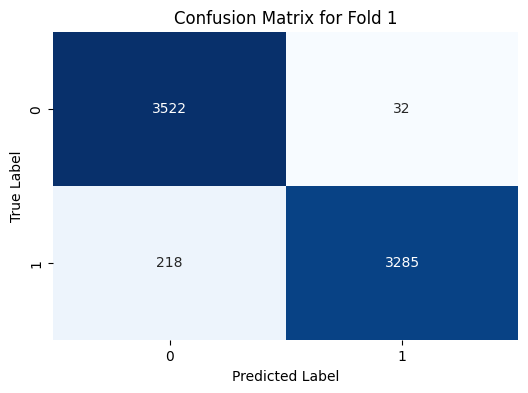

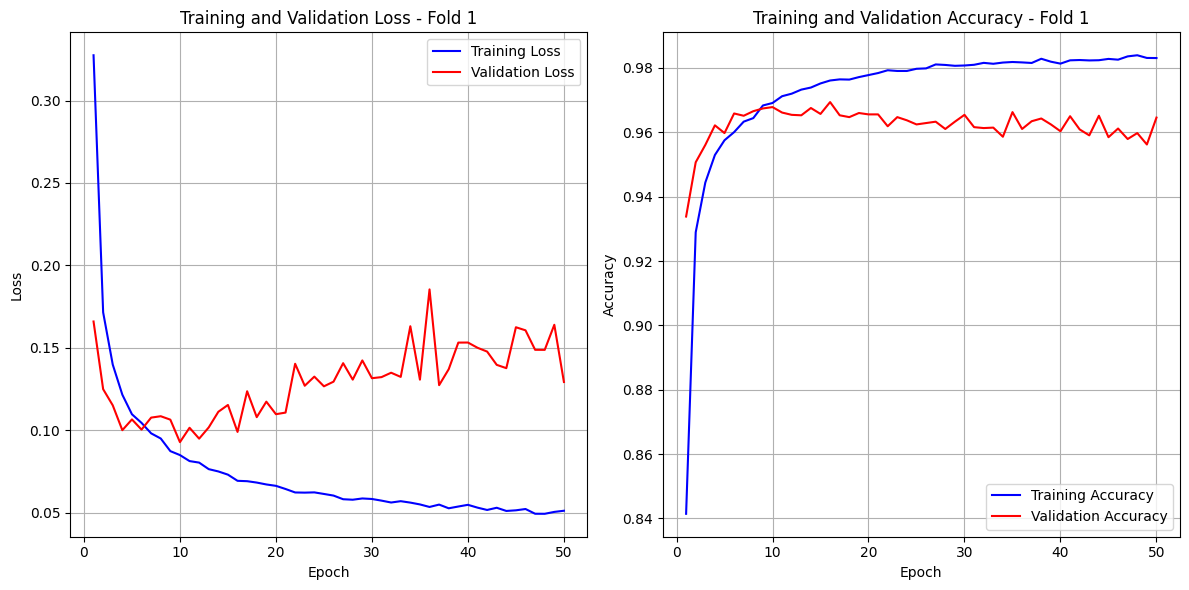


Fold 2
Accuracy for fold 2: 95.31%
F1 Score for fold 2: 0.9530
              precision    recall  f1-score   support

           0       0.92      0.99      0.95      3519
           1       0.99      0.92      0.95      3538

    accuracy                           0.95      7057
   macro avg       0.96      0.95      0.95      7057
weighted avg       0.96      0.95      0.95      7057



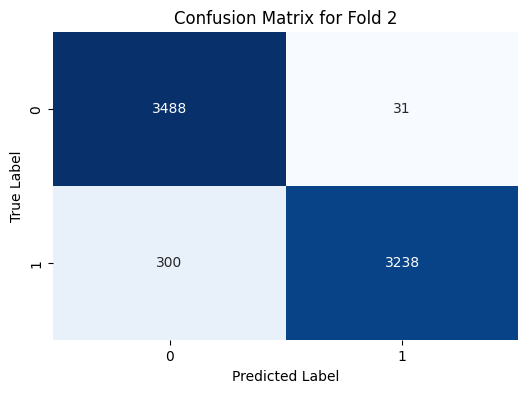

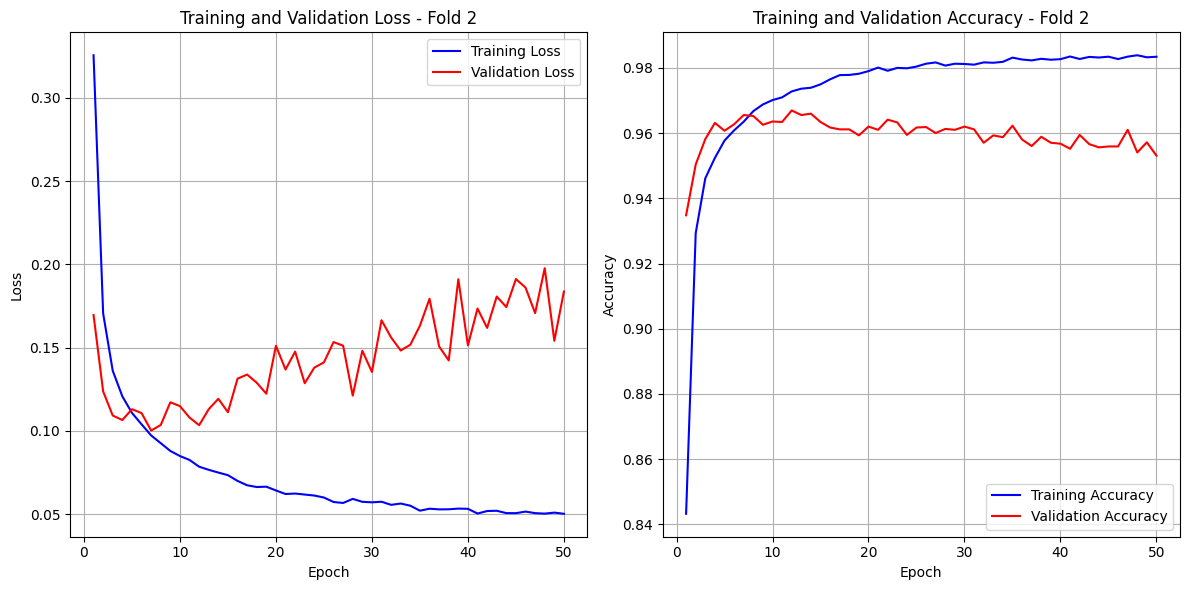


Fold 3
Accuracy for fold 3: 95.63%
F1 Score for fold 3: 0.9563
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      3575
           1       0.99      0.92      0.95      3481

    accuracy                           0.96      7056
   macro avg       0.96      0.96      0.96      7056
weighted avg       0.96      0.96      0.96      7056



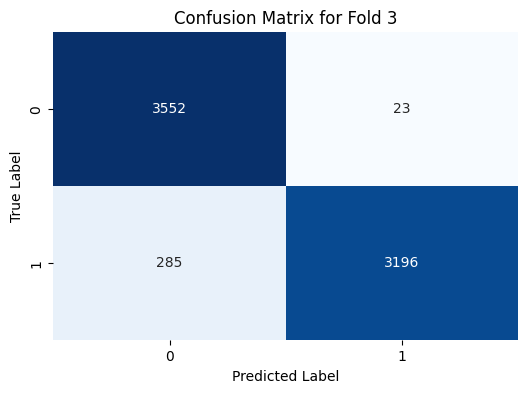

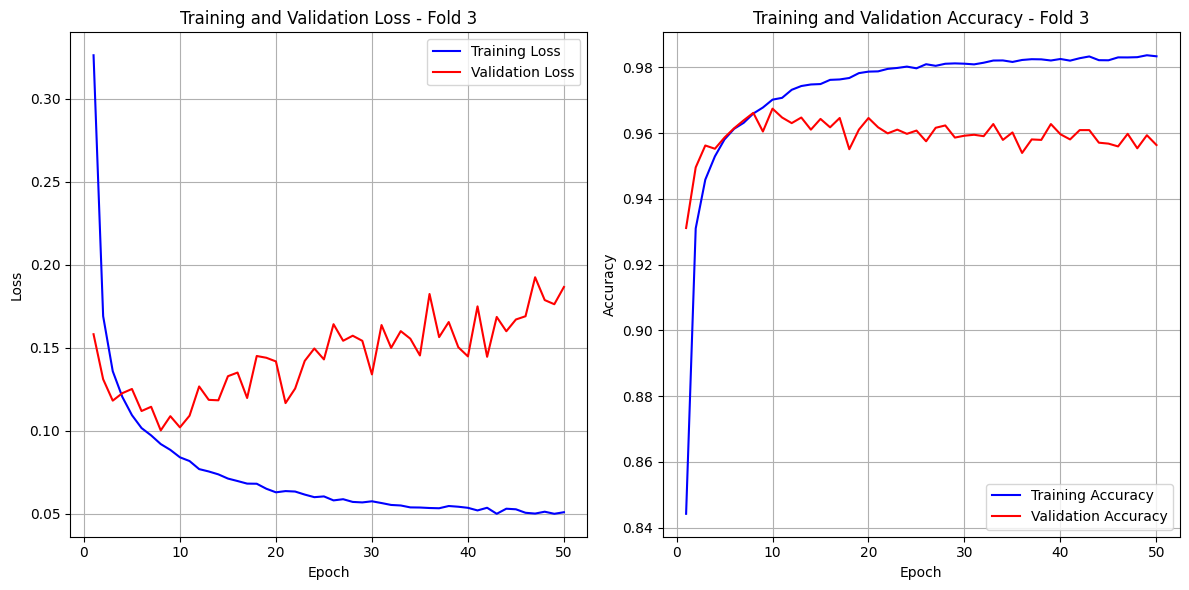


Fold 4
Accuracy for fold 4: 95.63%
F1 Score for fold 4: 0.9563
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      3464
           1       0.99      0.92      0.96      3592

    accuracy                           0.96      7056
   macro avg       0.96      0.96      0.96      7056
weighted avg       0.96      0.96      0.96      7056



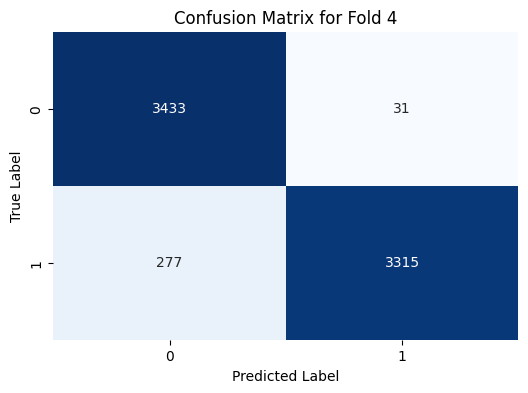

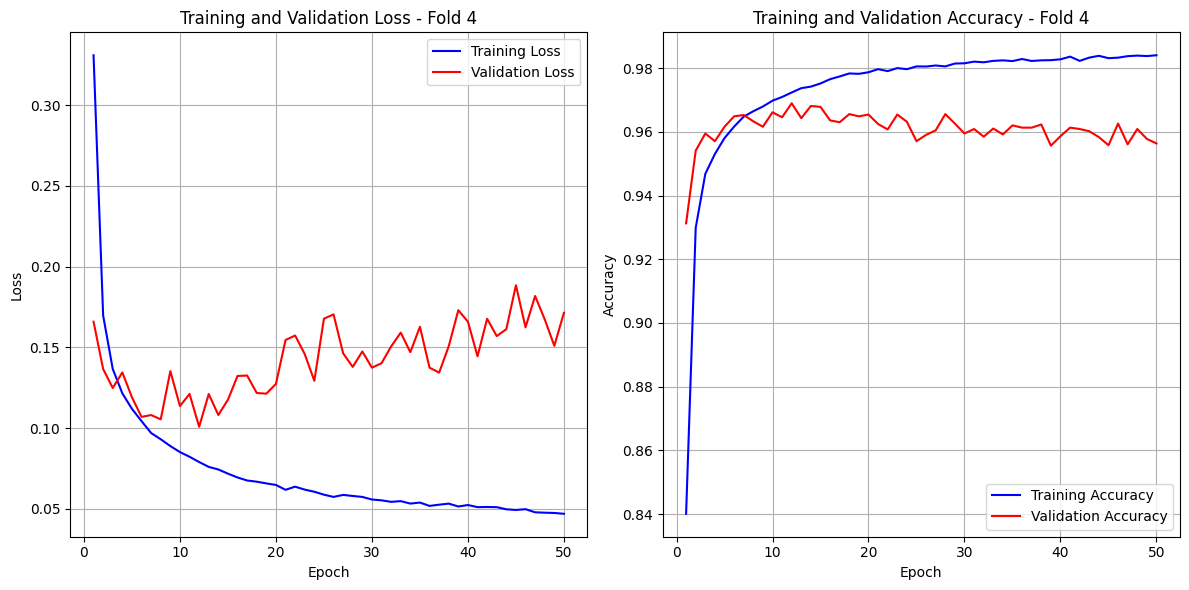


Fold 5
Accuracy for fold 5: 95.78%
F1 Score for fold 5: 0.9577
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      3496
           1       0.99      0.93      0.96      3560

    accuracy                           0.96      7056
   macro avg       0.96      0.96      0.96      7056
weighted avg       0.96      0.96      0.96      7056



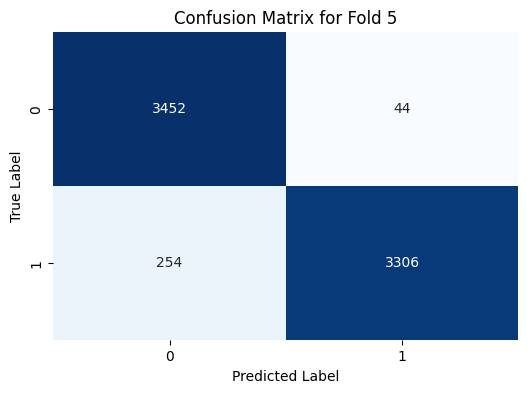

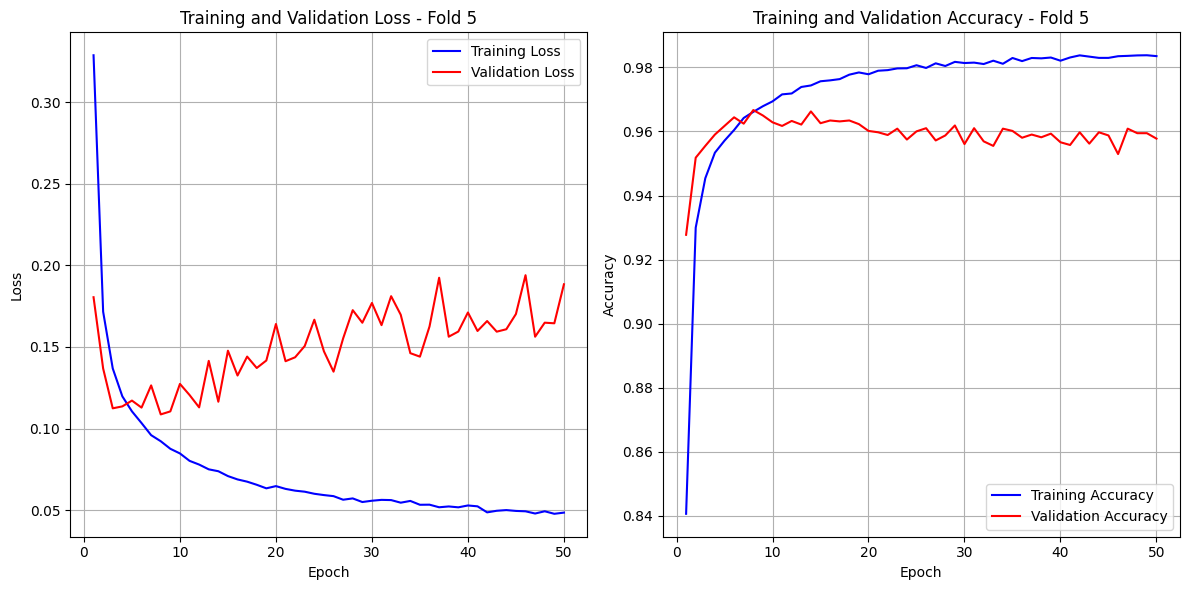


Fold 6
Accuracy for fold 6: 95.55%
F1 Score for fold 6: 0.9554
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      3575
           1       0.99      0.91      0.95      3481

    accuracy                           0.96      7056
   macro avg       0.96      0.95      0.96      7056
weighted avg       0.96      0.96      0.96      7056



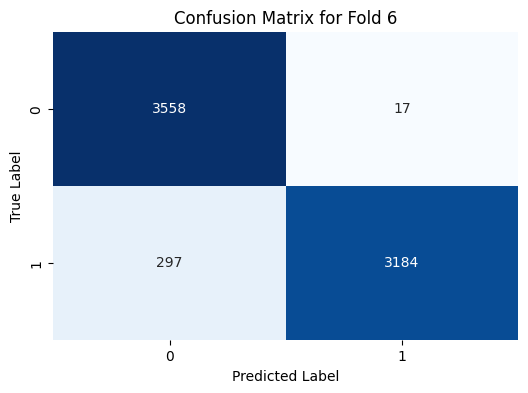

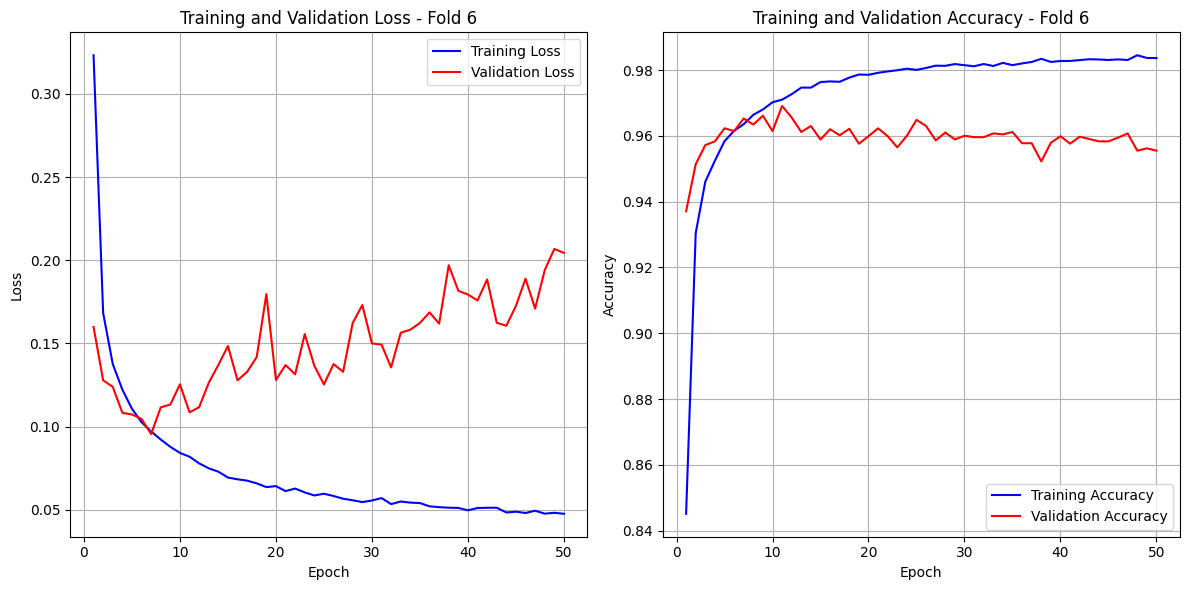


Fold 7
Accuracy for fold 7: 95.44%
F1 Score for fold 7: 0.9543
              precision    recall  f1-score   support

           0       0.92      0.99      0.96      3493
           1       0.99      0.92      0.95      3563

    accuracy                           0.95      7056
   macro avg       0.96      0.95      0.95      7056
weighted avg       0.96      0.95      0.95      7056



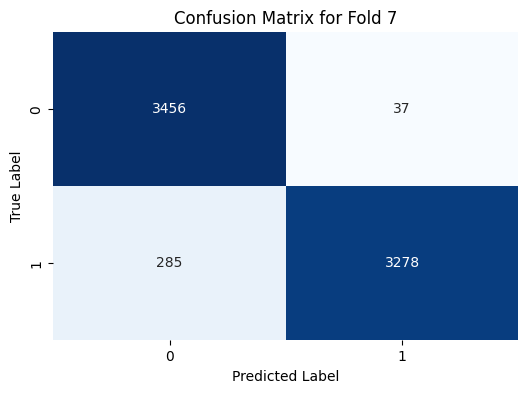

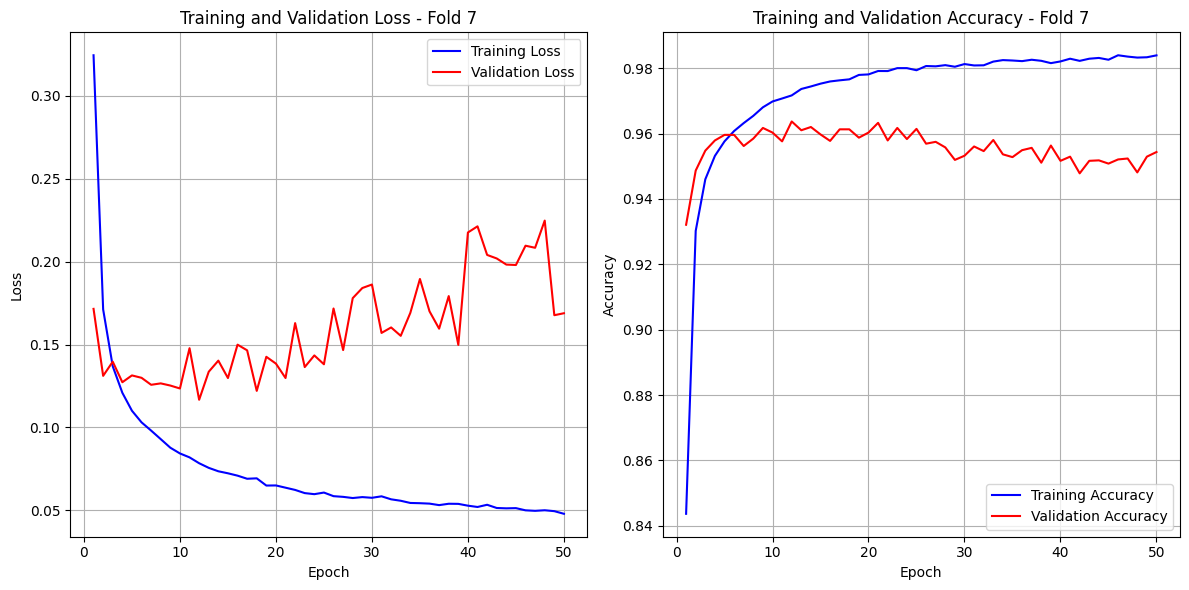


Fold 8
Accuracy for fold 8: 95.59%
F1 Score for fold 8: 0.9559
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      3552
           1       0.99      0.92      0.95      3504

    accuracy                           0.96      7056
   macro avg       0.96      0.96      0.96      7056
weighted avg       0.96      0.96      0.96      7056



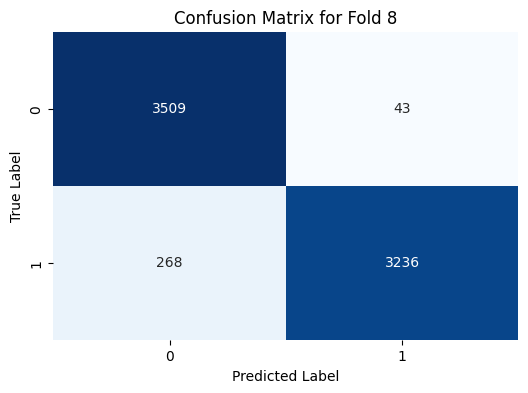

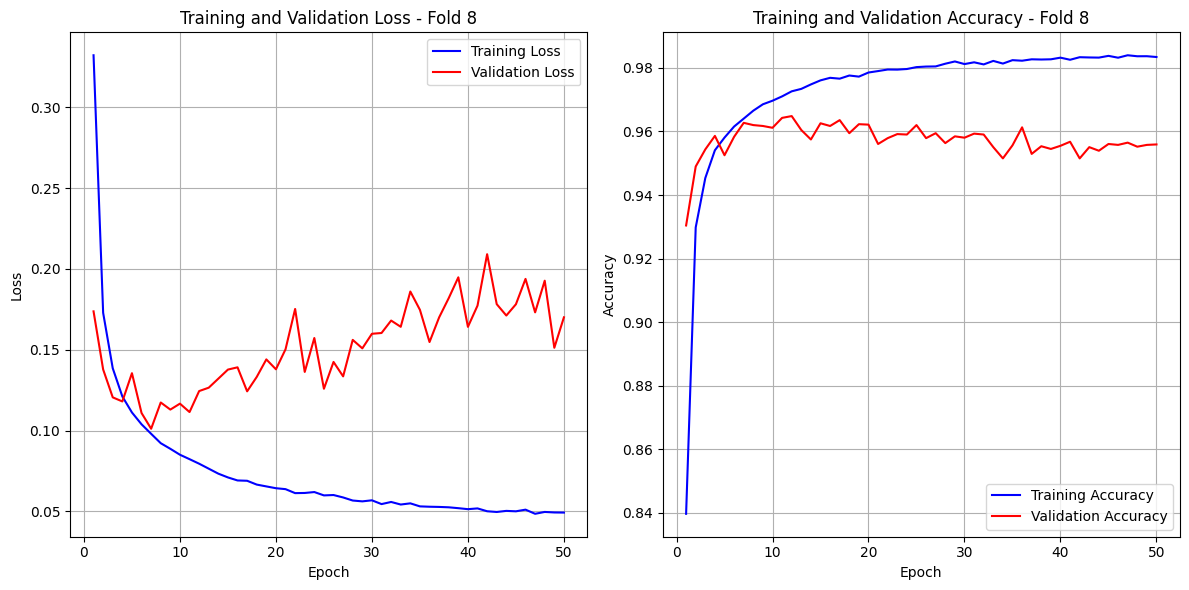


Fold 9
Accuracy for fold 9: 95.32%
F1 Score for fold 9: 0.9532
              precision    recall  f1-score   support

           0       0.92      0.99      0.95      3501
           1       0.99      0.92      0.95      3555

    accuracy                           0.95      7056
   macro avg       0.96      0.95      0.95      7056
weighted avg       0.96      0.95      0.95      7056



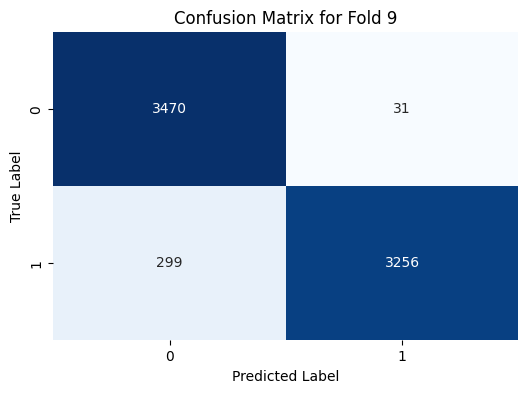

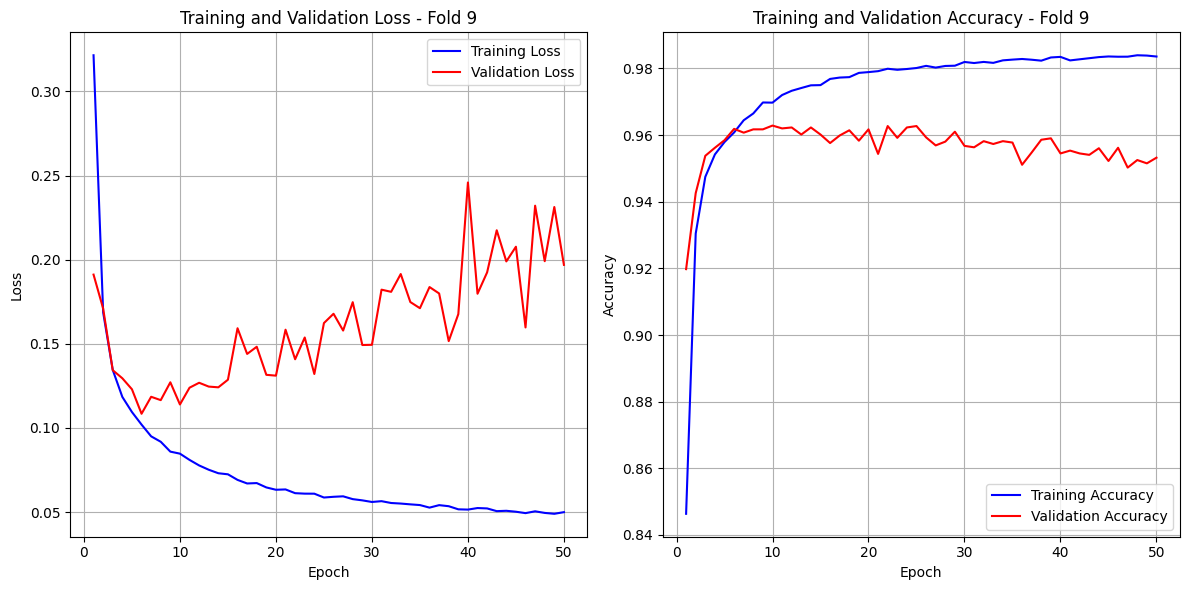


Fold 10
Accuracy for fold 10: 95.10%
F1 Score for fold 10: 0.9509
              precision    recall  f1-score   support

           0       0.92      0.99      0.95      3552
           1       0.99      0.91      0.95      3504

    accuracy                           0.95      7056
   macro avg       0.95      0.95      0.95      7056
weighted avg       0.95      0.95      0.95      7056



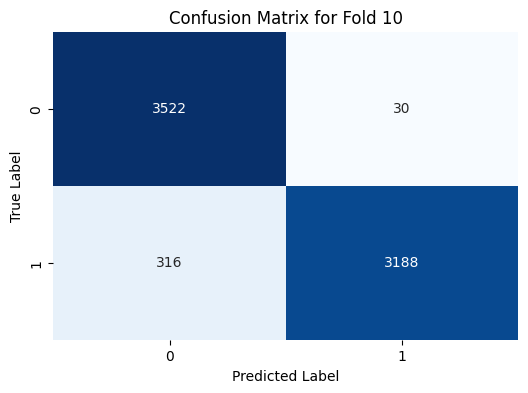

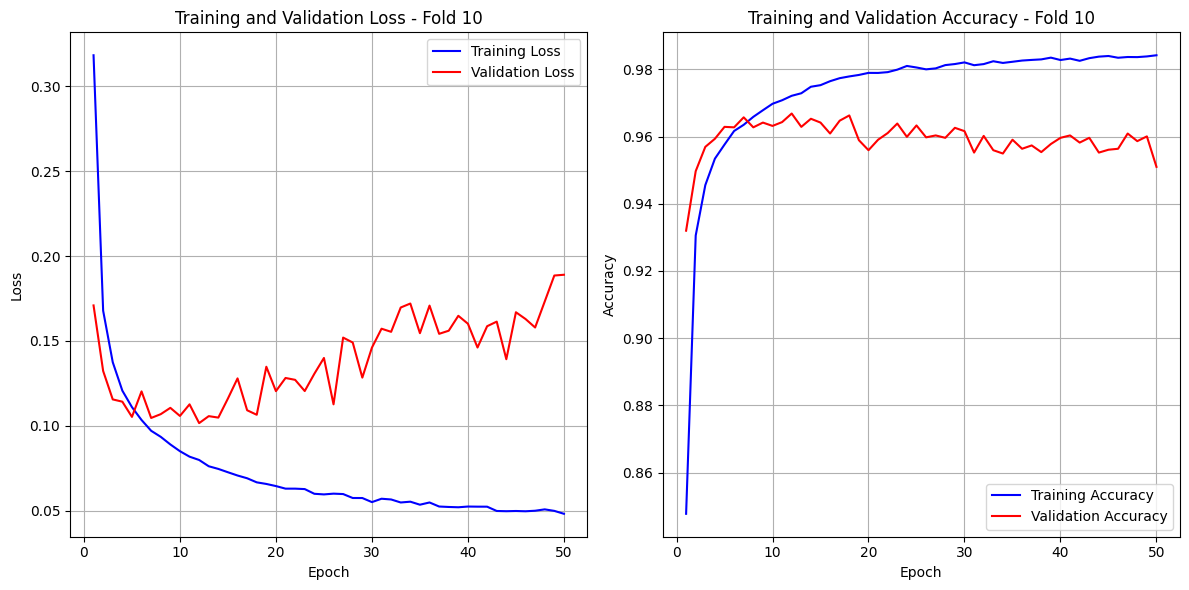


Average Accuracy: 95.58%
Average F1 Score: 0.9558


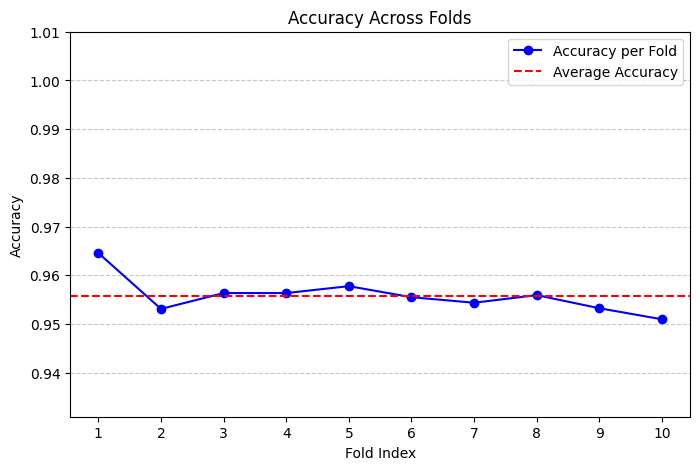

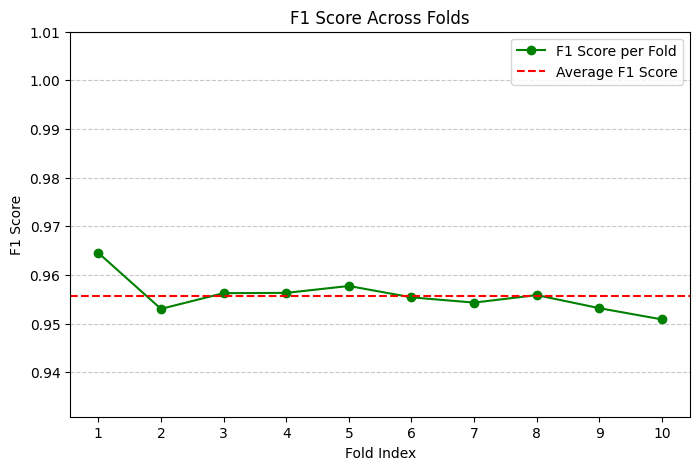

In [15]:
#TIDAK EARLY STOPPING

import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns

# Define Transformer Model 
class TransformerModel(nn.Module):
    def __init__(self, input_dim, num_classes, d_model=64, nhead=2, num_layers=2, dropout=0.3):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, d_model) #Mengubah dimensi input (input_dim) menjadi dimensi internal (d_model).
        self.transformer_encoder = nn.TransformerEncoder(  #Mendefinisikan struktur encoder Transformer.
            nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout, batch_first=True),
            num_layers=num_layers
        )
        self.fc = nn.Linear(d_model, num_classes) #Mengubah output Transformer menjadi prediksi akhir untuk jumlah kelas (num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.embedding(x)
        x = self.dropout(x)  # Apply dropout after embedding
        x = x.unsqueeze(1)  # Add sequence dimension agar sesuai dengan format input Transformer.
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)  # Average pooling untuk merangkum informasi penting dari seluruh sequence untuk membuat prediksi akhir.
        return self.fc(x)

kf = KFold(n_splits=10, shuffle=True, random_state=50)
all_accuracy, all_f1_scores = [], []
conf_matrix_list = []
average_train_losses, average_val_losses = [], []
average_train_accuracies, average_val_accuracies = [], []

for fold, (train_index, val_index) in enumerate(kf.split(X_resampled_combined)):
    print(f'\nFold {fold + 1}')

    # Split data hasil SMOTE
    X_train, X_val = X_resampled_combined.iloc[train_index], X_resampled_combined.iloc[val_index]
    y_train, y_val = y_resampled.iloc[train_index], y_resampled.iloc[val_index]

    # Ensure numeric data and handle missing values
    X_train = X_train.apply(pd.to_numeric, errors='coerce').fillna(0)
    X_val = X_val.apply(pd.to_numeric, errors='coerce').fillna(0)

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    # Convert to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train_scaled)
    y_train_tensor = torch.LongTensor(y_train.values)
    X_val_tensor = torch.FloatTensor(X_val_scaled)
    y_val_tensor = torch.LongTensor(y_val.values)

    # Create DataLoader
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    # Compute class weights to handle class imbalance
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weights_tensor = torch.FloatTensor(class_weights).to('cpu')

    # Initialize model, loss, and optimizer
    model = TransformerModel(input_dim=X_train_tensor.shape[1], num_classes=len(np.unique(y_resampled)), d_model=64, nhead=2, num_layers=2, dropout=0.3)
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)

    # Train the model
    num_epochs = 50
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        correct_train, total_train = 0, 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

            # Train accuracy
            _, predicted_train = torch.max(outputs, 1)
            correct_train += (predicted_train == labels).sum().item()
            total_train += labels.size(0)

        avg_train_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        train_accuracy = correct_train / total_train
        train_accuracies.append(train_accuracy)

        # Validate the model
        model.eval()
        with torch.no_grad():
            y_pred_probs = model(X_val_tensor)
            val_loss = criterion(y_pred_probs, y_val_tensor).item()
            val_losses.append(val_loss)
            _, y_pred = torch.max(y_pred_probs, 1)

        val_accuracy = accuracy_score(y_val, y_pred.numpy())
        val_accuracies.append(val_accuracy)

    # Metrics calculation
    conf_matrix = confusion_matrix(y_val, y_pred.numpy())
    conf_matrix_list.append(conf_matrix)
    all_accuracy.append(val_accuracies[-1])
    f1 = f1_score(y_val, y_pred.numpy(), average='weighted')
    all_f1_scores.append(f1)

    # Print fold results
    print(f"Accuracy for fold {fold + 1}: {val_accuracies[-1] * 100:.2f}%")
    print(f"F1 Score for fold {fold + 1}: {f1:.4f}")
    print(classification_report(y_val, y_pred.numpy()))

    # Plot confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='.0f', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for Fold {fold + 1}')
    plt.show()

    # Plot Training and Validation Loss per Epoch for this fold
    plt.figure(figsize=(12, 6))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss', color='blue')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', color='red')
    plt.title(f'Training and Validation Loss - Fold {fold + 1}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Training Accuracy', color='blue')
    plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy', color='red')
    plt.title(f'Training and Validation Accuracy - Fold {fold + 1}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Average Metrics Across All Folds
print(f'\nAverage Accuracy: {np.mean(all_accuracy) * 100:.2f}%')
print(f'Average F1 Score: {np.mean(all_f1_scores):.4f}')  

# Plotting Accuracy and F1 Score for all folds
folds = range(1, len(all_accuracy) + 1)

# Accuracy Across Folds
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(all_accuracy) + 1), all_accuracy, color='blue', marker='o', label='Accuracy per Fold')
plt.axhline(y=np.mean(all_accuracy), color='red', linestyle='--', label='Average Accuracy')
plt.title('Accuracy Across Folds')
plt.xlabel('Fold Index')
plt.ylabel('Accuracy')
plt.xticks(range(1, len(all_accuracy) + 1))  # Set x-ticks for each fold
plt.ylim(min(all_accuracy) - 0.02, 1.01)  # Slightly expand Y-axis for better visualization
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# F1 Score Across Folds
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(all_f1_scores) + 1), all_f1_scores, color='green', marker='o', label='F1 Score per Fold')
plt.axhline(y=np.mean(all_f1_scores), color='red', linestyle='--', label='Average F1 Score')
plt.title('F1 Score Across Folds')
plt.xlabel('Fold Index')
plt.ylabel('F1 Score')
plt.xticks(range(1, len(all_f1_scores) + 1))  # Set x-ticks for each fold
plt.ylim(min(all_f1_scores) - 0.02, 1.01)  # Slightly expand Y-axis for better visualization
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


Test Accuracy: 97.45%
Test F1 Score: 0.9745
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      7068
           1       0.99      0.96      0.97      7045

    accuracy                           0.97     14113
   macro avg       0.97      0.97      0.97     14113
weighted avg       0.97      0.97      0.97     14113



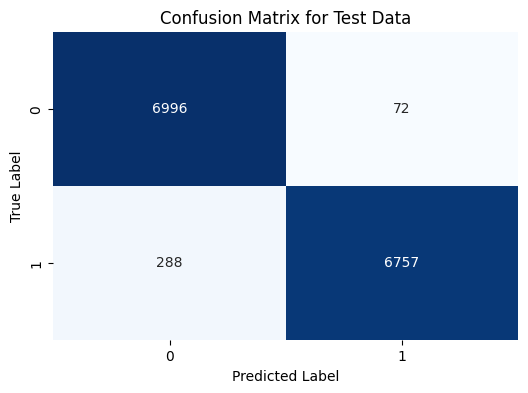

In [16]:
#DATA TESTING
# Load the best model from the final fold
best_model = TransformerModel(input_dim=X_train_tensor.shape[1], num_classes=len(np.unique(y_resampled)), d_model=32, nhead=2, num_layers=2, dropout=0.3)
best_model.load_state_dict(torch.load(f'model_best_fold_{fold + 1}.pt',  weights_only=True))

# Prepare the testing data (you may need to rescale the data, like during training)
X_test_scaled = scaler.transform(X_test)  # Use the scaler fitted on the training data
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.LongTensor(y_test.values)

# Evaluate on the test set
best_model.eval()
with torch.no_grad():
    y_pred_probs = best_model(X_test_tensor)
    _, y_pred = torch.max(y_pred_probs, 1)

# Calculate performance metrics on the test set
test_accuracy = accuracy_score(y_test, y_pred.numpy())
test_f1 = f1_score(y_test, y_pred.numpy(), average='weighted')
conf_matrix_test = confusion_matrix(y_test, y_pred.numpy())

# Print test results
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test F1 Score: {test_f1:.4f}")
print(classification_report(y_test, y_pred.numpy()))

# Plot Confusion Matrix for Test Set
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_test, annot=True, fmt='.0f', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Test Data')
plt.show()

# Optionally, plot accuracy and F1 score for the test set if you want to track them


# **Hyperparameter Tuning (Best Hyperparameter sama dengan default**

In [20]:
from itertools import product
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, f1_score
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm  # Untuk progress bar

# Hyperparameter grid
param_grid = {
    'learning_rate': [0.001, 0.0005],
    'num_layers': [2, 3],
    'd_model': [64, 128]
}

# Track the best hyperparameters
best_params = {}
best_f1_score = 0

# Label Encoding untuk kolom 'label'
label_encoder = LabelEncoder()
data['Label_encoded'] = label_encoder.fit_transform(data['label'])
class_names = label_encoder.classes_

# Define Transformer Model
class TransformerModel(nn.Module):
    def __init__(self, input_dim, num_classes, d_model=64, nhead=2, num_layers=2):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, d_model)  # Embedding layer
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True),
            num_layers=num_layers
        )
        self.fc = nn.Linear(d_model, num_classes)  # Output layer

    def forward(self, x):
        x = self.embedding(x)  # Embed the input features
        x = x.unsqueeze(1)  # Add sequence dimension (batch_size, seq_length, feature_dim)
        x = self.transformer_encoder(x)  # Pass through the transformer encoder
        x = x.mean(dim=1)  # Average pooling
        return self.fc(x)  # Final output

# Progress bar for parameter tuning
param_combinations = list(product(*param_grid.values()))
print(f"Fitting {len(param_combinations)} combinations...")

for params in tqdm(param_combinations, desc="Hyperparameter Tuning"):
    lr, num_layers, d_model = params
    print(f"Testing params: learning_rate={lr}, num_layers={num_layers}, d_model={d_model}")
    
    all_f1_scores = []

    # 5-fold Cross Validation
    kf = KFold(n_splits=10, shuffle=True, random_state=50)
    for train_index, val_index in kf.split(data):
        X_train, X_val = data.drop(columns=['label', 'Label_encoded']).iloc[train_index], \
                         data.drop(columns=['label', 'Label_encoded']).iloc[val_index]
        y_train, y_val = data['Label_encoded'].iloc[train_index], data['Label_encoded'].iloc[val_index]

        # Preprocessing
        X_train = X_train.apply(pd.to_numeric, errors='coerce').fillna(0)
        X_val = X_val.apply(pd.to_numeric, errors='coerce').fillna(0)
        X_train_tensor = torch.FloatTensor(X_train.values)
        y_train_tensor = torch.LongTensor(y_train.values)
        X_val_tensor = torch.FloatTensor(X_val.values)
        y_val_tensor = torch.LongTensor(y_val.values)

        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

        # Initialize model
        model = TransformerModel(input_dim=X_train_tensor.shape[1],
                                 num_classes=len(class_names),
                                 d_model=d_model,
                                 num_layers=num_layers)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        # Training loop
        for epoch in range(50):  # Example epoch count
            model.train()
            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

        # Validation
        model.eval()
        with torch.no_grad():
            y_pred_probs = model(X_val_tensor)
            _, y_pred = torch.max(y_pred_probs, 1)
        f1 = f1_score(y_val, y_pred.numpy(), average='weighted')
        all_f1_scores.append(f1)

    # Average F1-score across folds
    avg_f1_score = np.mean(all_f1_scores)

    # Track the best hyperparameters
    if avg_f1_score > best_f1_score:
        best_f1_score = avg_f1_score
        best_params = {
            'learning_rate': lr,
            'num_layers': num_layers,
            'd_model': d_model
        }

# Output the best parameters
print(f"Best Parameters: {best_params}")
print(f"Best F1-Score: {best_f1_score:.4f}")


Fitting 8 combinations...


Hyperparameter Tuning:   0%|                                                                     | 0/8 [00:00<?, ?it/s]

Testing params: learning_rate=0.001, num_layers=2, d_model=64


Hyperparameter Tuning:  12%|██████▋                                              | 1/8 [4:44:56<33:14:38, 17096.92s/it]

Testing params: learning_rate=0.001, num_layers=2, d_model=128


Hyperparameter Tuning:  25%|█████████████                                       | 2/8 [11:16:31<34:45:59, 20859.99s/it]

Testing params: learning_rate=0.001, num_layers=3, d_model=64


Hyperparameter Tuning:  38%|███████████████████▌                                | 3/8 [17:34:37<30:07:49, 21693.88s/it]

Testing params: learning_rate=0.001, num_layers=3, d_model=128


Hyperparameter Tuning:  50%|██████████████████████████                          | 4/8 [26:47:12<29:07:54, 26218.62s/it]

Testing params: learning_rate=0.0005, num_layers=2, d_model=64


Hyperparameter Tuning:  62%|████████████████████████████████▌                   | 5/8 [31:57:55<19:34:20, 23486.90s/it]

Testing params: learning_rate=0.0005, num_layers=2, d_model=128


Hyperparameter Tuning:  75%|███████████████████████████████████████             | 6/8 [39:06:20<13:28:02, 24241.18s/it]

Testing params: learning_rate=0.0005, num_layers=3, d_model=64


Hyperparameter Tuning:  88%|██████████████████████████████████████████████▍      | 7/8 [48:06:24<7:28:29, 26909.59s/it]

Testing params: learning_rate=0.0005, num_layers=3, d_model=128


Hyperparameter Tuning: 100%|███████████████████████████████████████████████████████| 8/8 [57:46:45<00:00, 26000.71s/it]

Best Parameters: {'learning_rate': 0.001, 'num_layers': 2, 'd_model': 64}
Best F1-Score: 0.5386


# **CLASSIFICATION With Hyperparameter Tuning**


Fold 1
Early stopping triggered at epoch 17
Accuracy for fold 1: 98.59%
F1 Score for fold 1: 0.9860
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1777
           1       1.00      0.98      0.99      3483

    accuracy                           0.99      5260
   macro avg       0.98      0.99      0.98      5260
weighted avg       0.99      0.99      0.99      5260



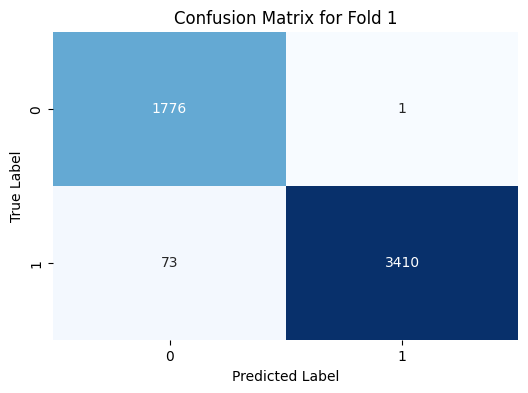

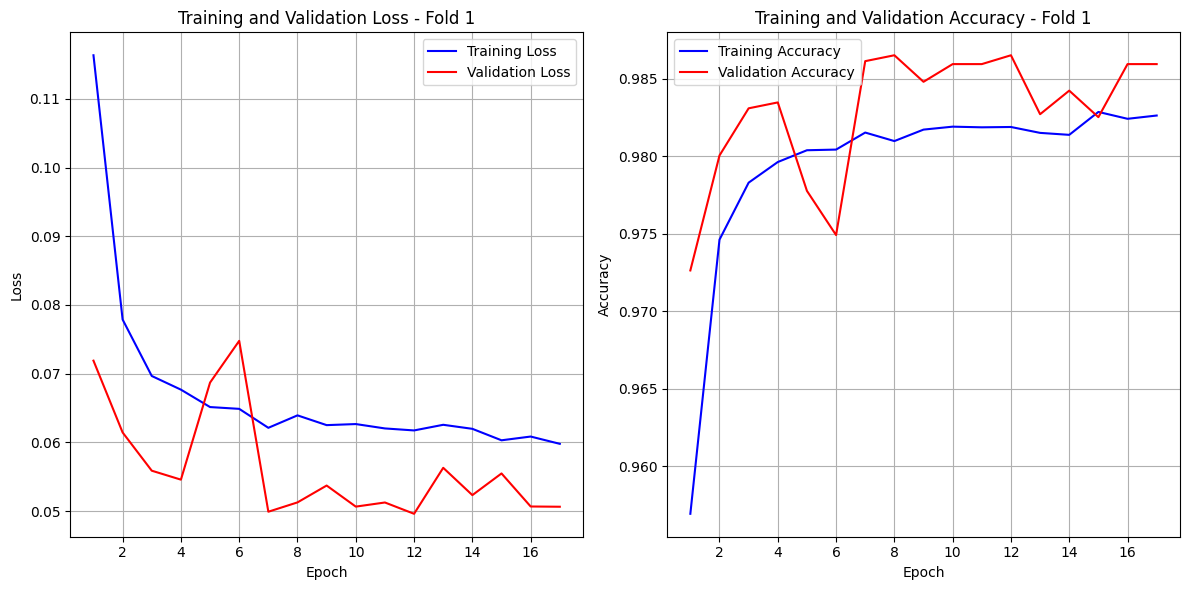


Fold 2
Early stopping triggered at epoch 31
Accuracy for fold 2: 98.65%
F1 Score for fold 2: 0.9866
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1745
           1       1.00      0.98      0.99      3515

    accuracy                           0.99      5260
   macro avg       0.98      0.99      0.98      5260
weighted avg       0.99      0.99      0.99      5260



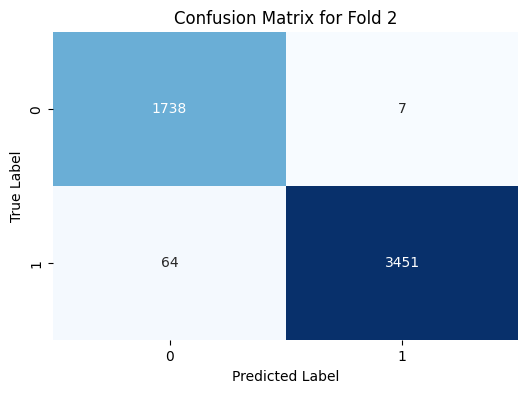

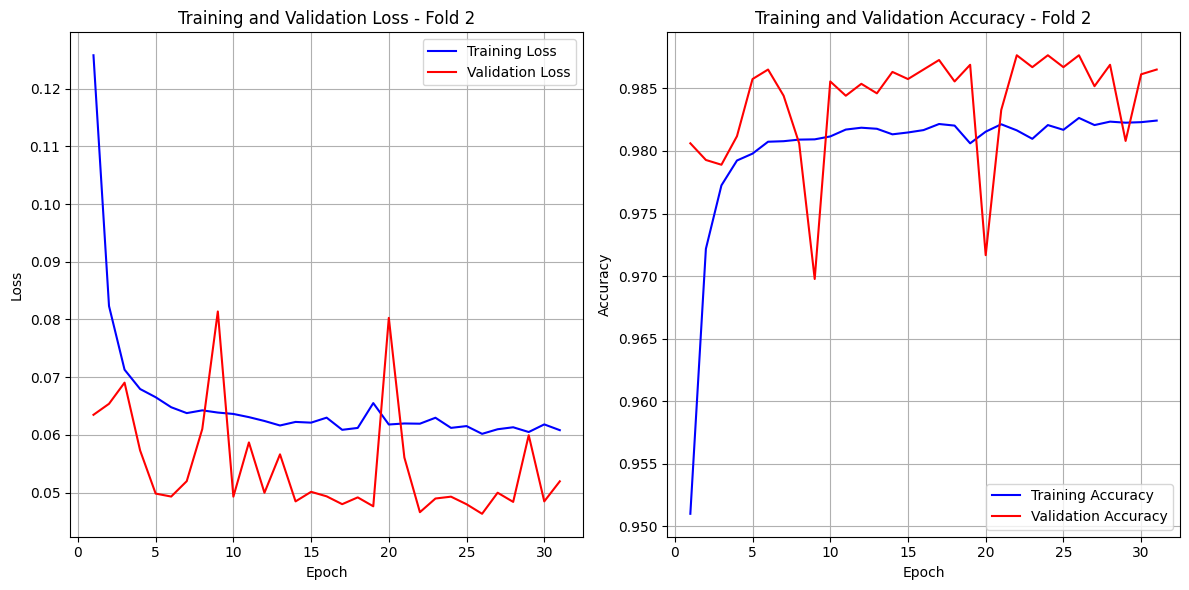


Fold 3
Early stopping triggered at epoch 10
Accuracy for fold 3: 98.59%
F1 Score for fold 3: 0.9860
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1694
           1       1.00      0.98      0.99      3566

    accuracy                           0.99      5260
   macro avg       0.98      0.99      0.98      5260
weighted avg       0.99      0.99      0.99      5260



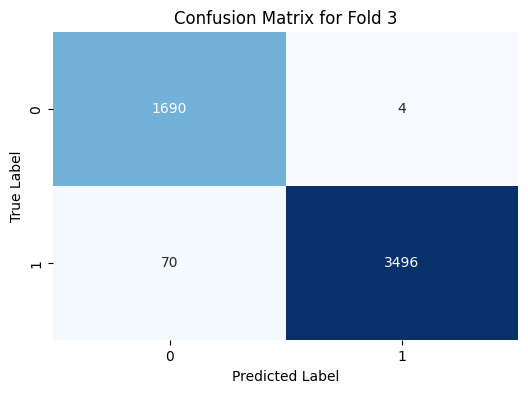

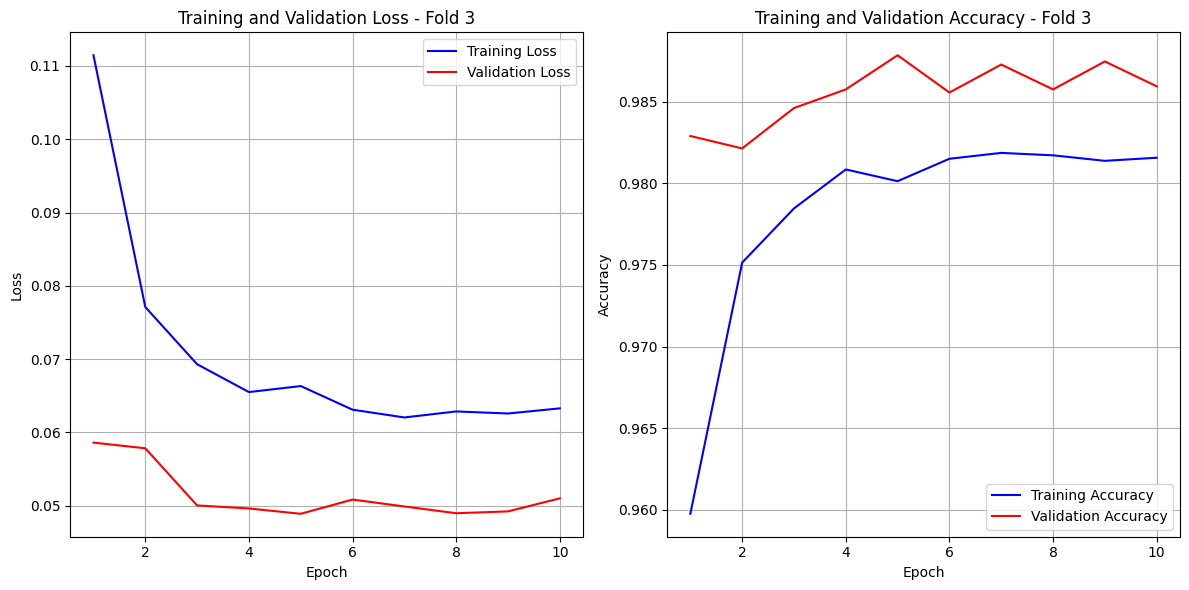


Fold 4
Early stopping triggered at epoch 14
Accuracy for fold 4: 98.25%
F1 Score for fold 4: 0.9826
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1752
           1       1.00      0.98      0.99      3508

    accuracy                           0.98      5260
   macro avg       0.98      0.99      0.98      5260
weighted avg       0.98      0.98      0.98      5260



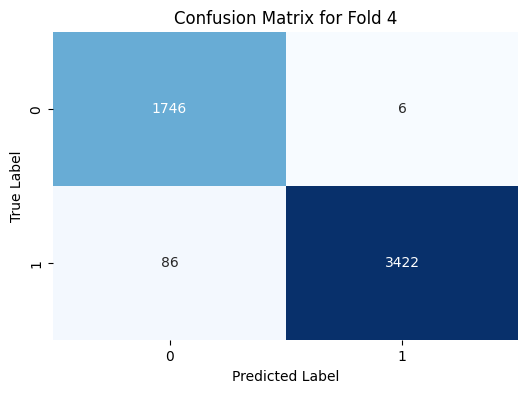

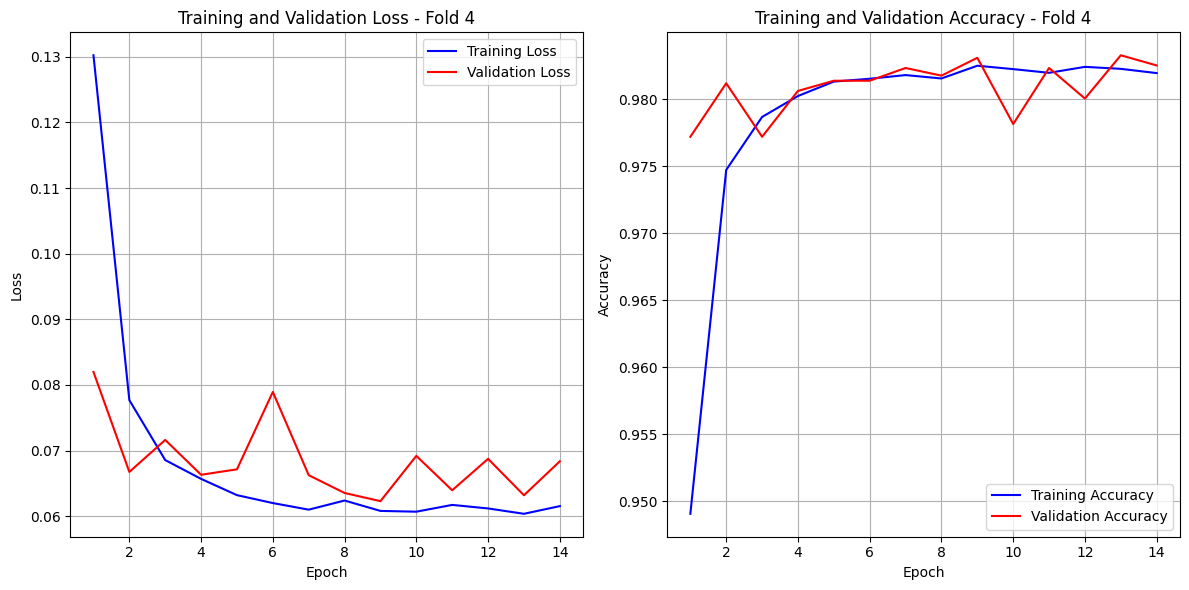


Fold 5
Early stopping triggered at epoch 10
Accuracy for fold 5: 98.00%
F1 Score for fold 5: 0.9802
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1740
           1       1.00      0.97      0.98      3520

    accuracy                           0.98      5260
   macro avg       0.97      0.99      0.98      5260
weighted avg       0.98      0.98      0.98      5260



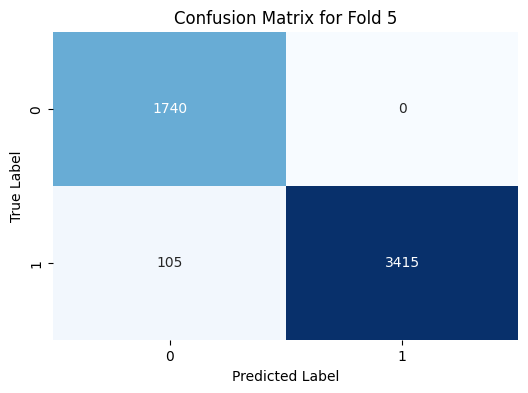

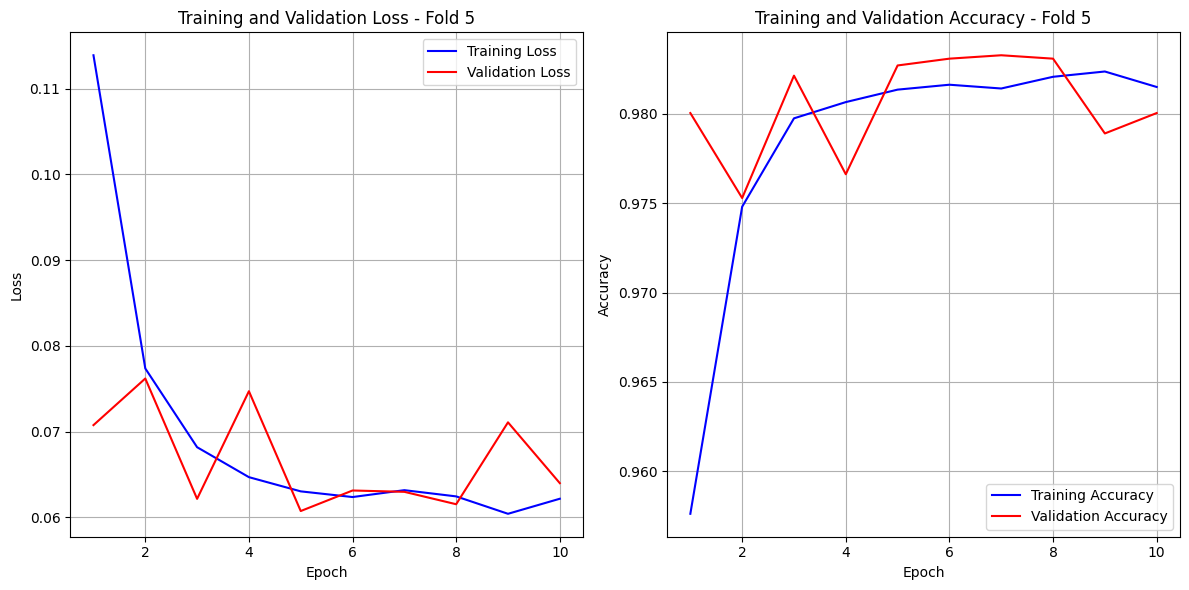


Fold 6
Early stopping triggered at epoch 11
Accuracy for fold 6: 98.08%
F1 Score for fold 6: 0.9809
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1691
           1       1.00      0.97      0.99      3569

    accuracy                           0.98      5260
   macro avg       0.97      0.99      0.98      5260
weighted avg       0.98      0.98      0.98      5260



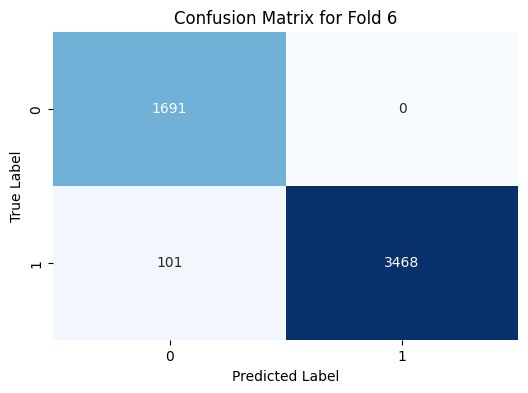

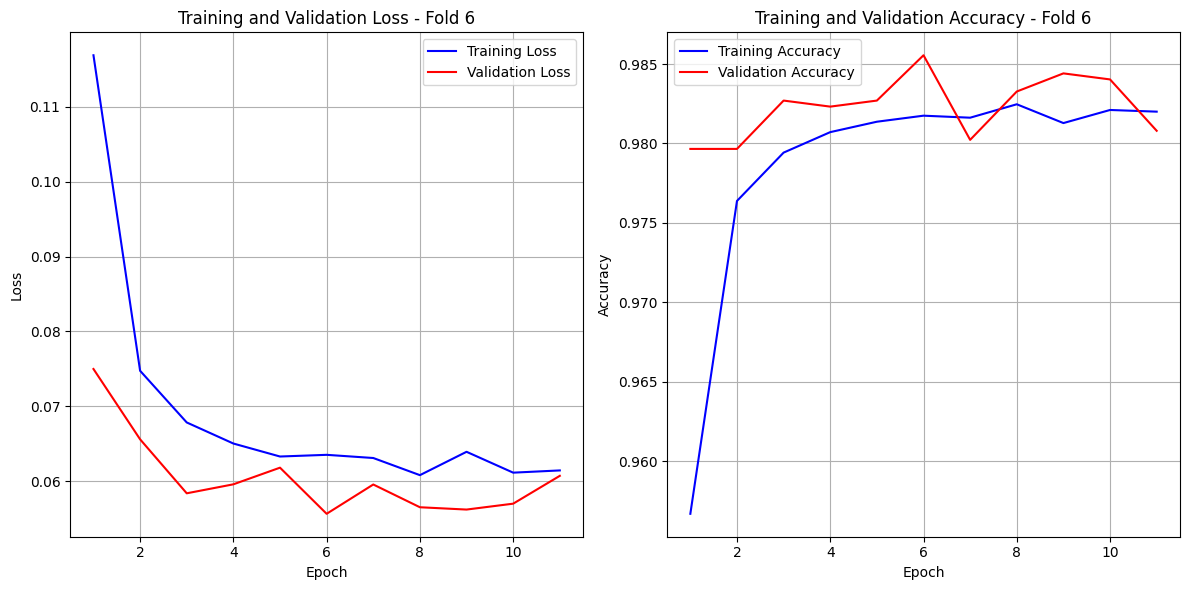


Fold 7
Early stopping triggered at epoch 9
Accuracy for fold 7: 98.12%
F1 Score for fold 7: 0.9813
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1719
           1       1.00      0.97      0.99      3541

    accuracy                           0.98      5260
   macro avg       0.97      0.99      0.98      5260
weighted avg       0.98      0.98      0.98      5260



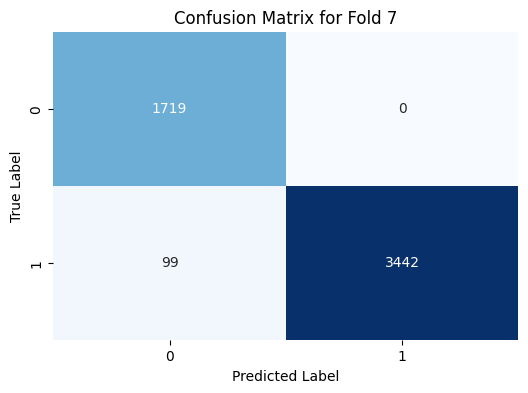

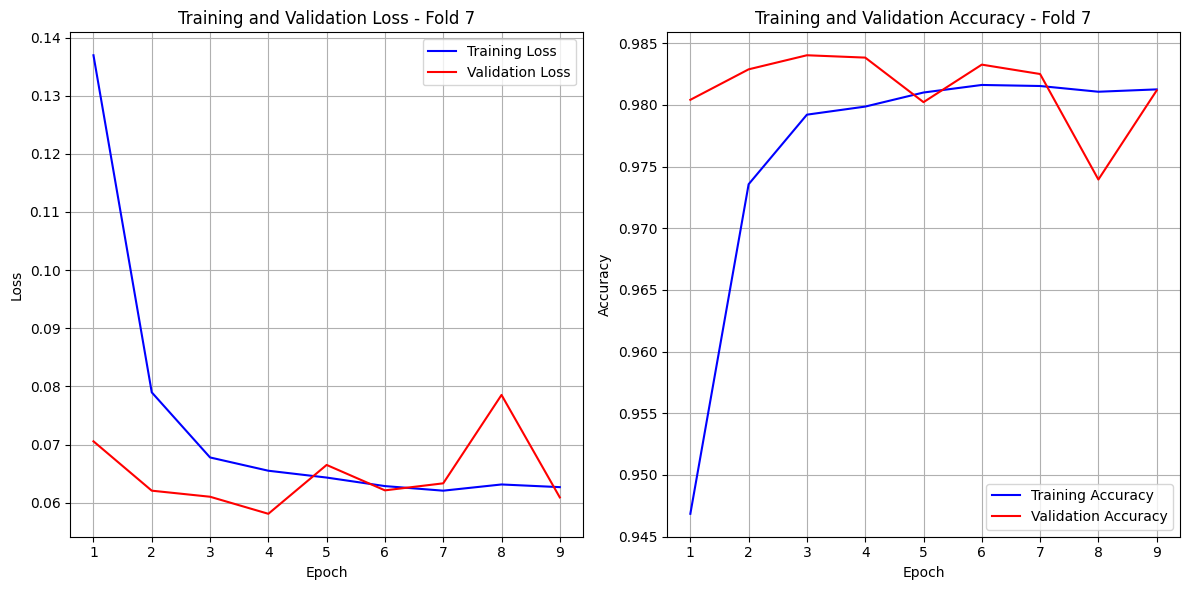


Fold 8
Early stopping triggered at epoch 12
Accuracy for fold 8: 98.08%
F1 Score for fold 8: 0.9809
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1777
           1       1.00      0.97      0.99      3483

    accuracy                           0.98      5260
   macro avg       0.97      0.99      0.98      5260
weighted avg       0.98      0.98      0.98      5260



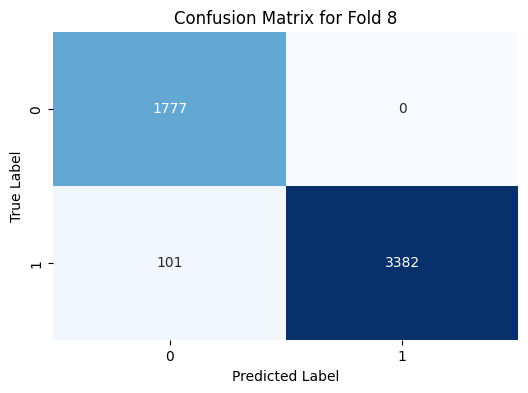

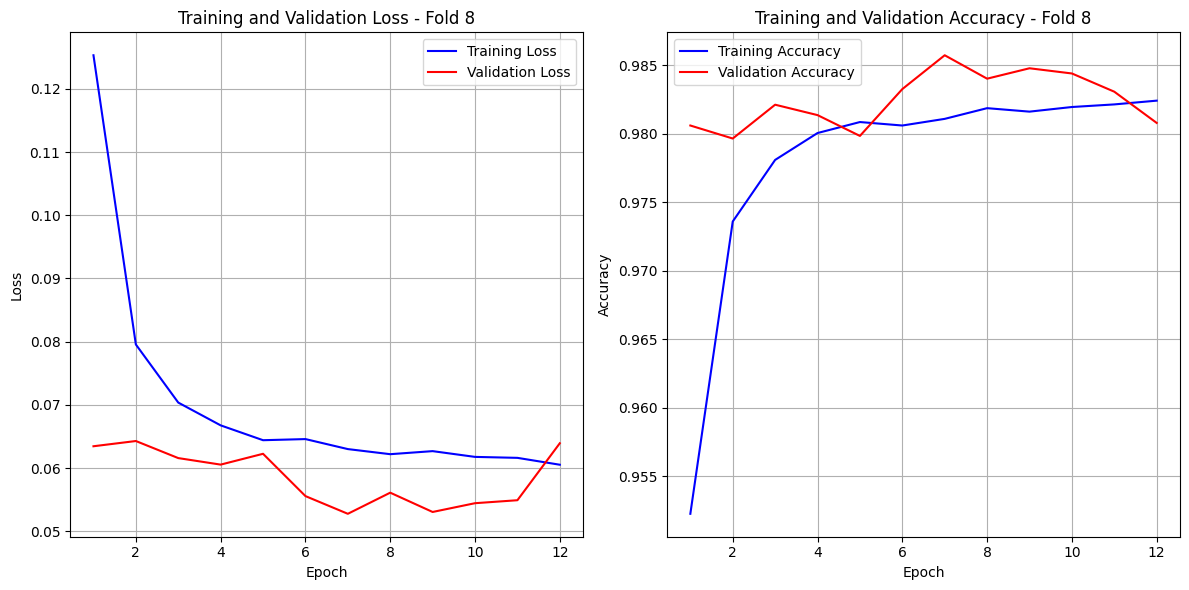


Fold 9
Early stopping triggered at epoch 11
Accuracy for fold 9: 98.19%
F1 Score for fold 9: 0.9821
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1695
           1       1.00      0.97      0.99      3565

    accuracy                           0.98      5260
   macro avg       0.97      0.99      0.98      5260
weighted avg       0.98      0.98      0.98      5260



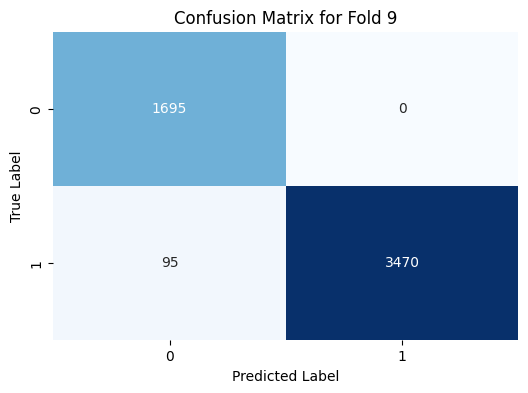

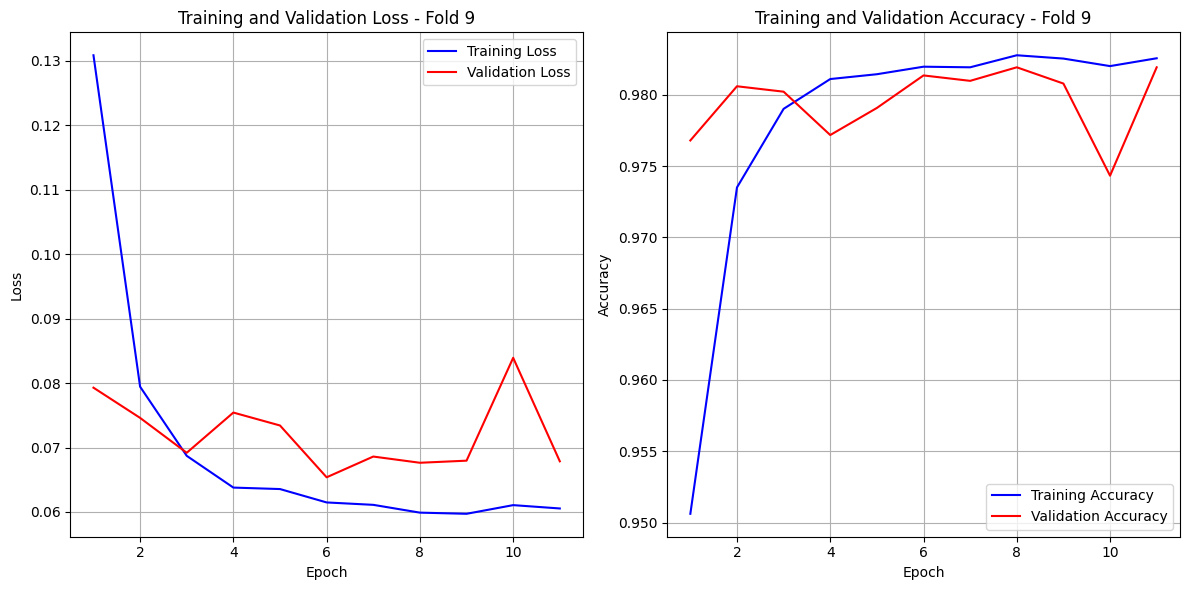


Fold 10
Early stopping triggered at epoch 10
Accuracy for fold 10: 98.16%
F1 Score for fold 10: 0.9817
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1729
           1       1.00      0.97      0.99      3531

    accuracy                           0.98      5260
   macro avg       0.97      0.99      0.98      5260
weighted avg       0.98      0.98      0.98      5260



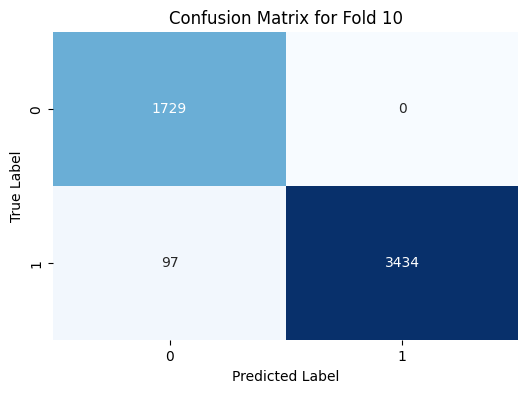

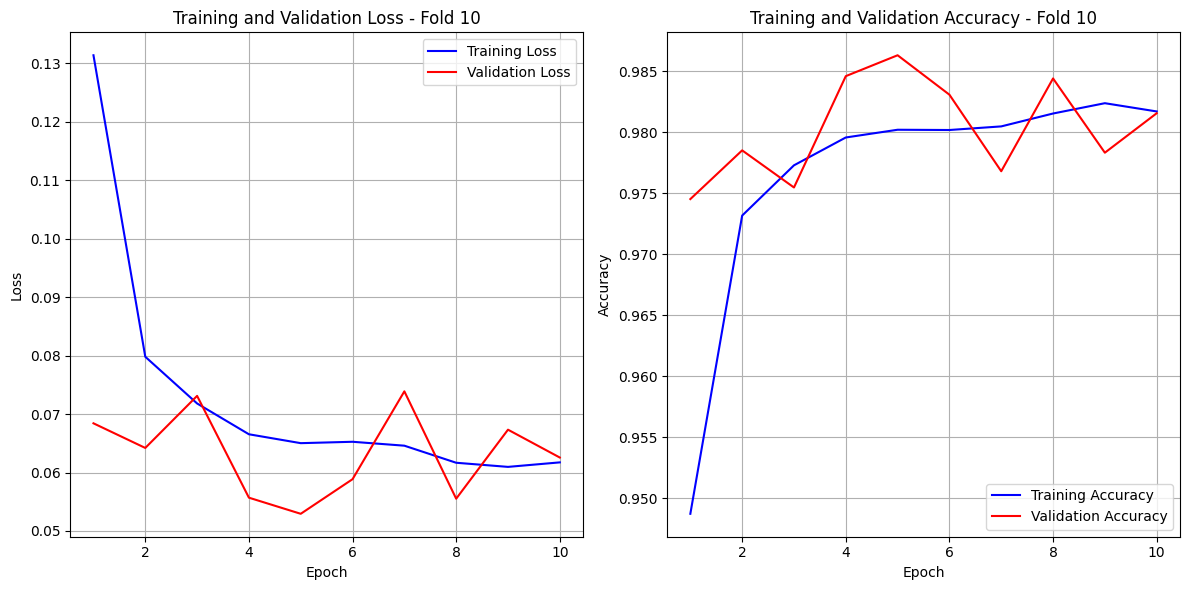


Average Accuracy: 98.27%
Average F1 Score: 0.9828


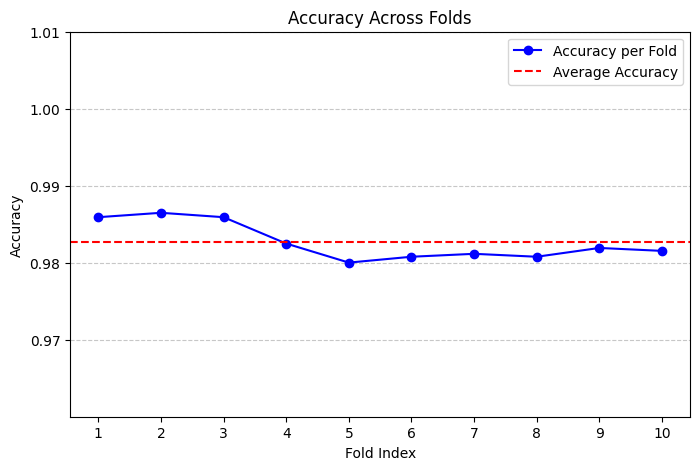

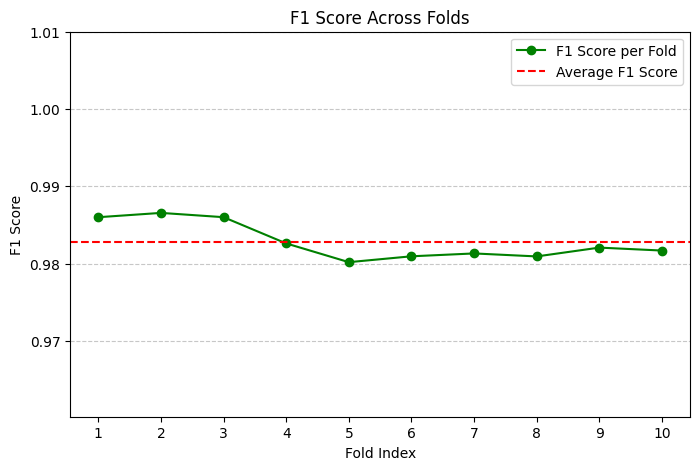

In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils.class_weight import compute_class_weight
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns

# Label Encoding
label_encoder = LabelEncoder()
data['Label_encoded'] = label_encoder.fit_transform(data['label'])
class_names = [str(class_name) for class_name in label_encoder.classes_]  # Mendapatkan nama-nama kelas

# Define Transformer Model with Dropout
class TransformerModel(nn.Module):
    def __init__(self, input_dim, num_classes, d_model=64, nhead=2, num_layers=2, dropout=0.3):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout, batch_first=True),
            num_layers=num_layers
        )
        self.fc = nn.Linear(d_model, num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.embedding(x)
        x = self.dropout(x)  # Apply dropout after embedding
        x = x.unsqueeze(1)  # Add sequence dimension
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)  # Average pooling
        return self.fc(x)

# KFold Cross-Validation
kf = KFold(n_splits=10, shuffle=True, random_state=50)
all_accuracy, all_f1_scores = [], []
conf_matrix_list = []
average_train_losses, average_val_losses = [], []
average_train_accuracies, average_val_accuracies = [], []

for fold, (train_index, val_index) in enumerate(kf.split(data)):
    print(f'\nFold {fold + 1}')

    # Split data
    X_train, X_val = data.drop(columns=['label', 'Label_encoded']).iloc[train_index], \
                     data.drop(columns=['label', 'Label_encoded']).iloc[val_index]
    y_train, y_val = data['Label_encoded'].iloc[train_index], data['Label_encoded'].iloc[val_index]

    # Ensure numeric data and handle missing values
    X_train = X_train.apply(pd.to_numeric, errors='coerce').fillna(0)
    X_val = X_val.apply(pd.to_numeric, errors='coerce').fillna(0)

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    # Convert to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train_scaled)
    y_train_tensor = torch.LongTensor(y_train.values)
    X_val_tensor = torch.FloatTensor(X_val_scaled)
    y_val_tensor = torch.LongTensor(y_val.values)

    # Create DataLoader
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    # Compute class weights to handle class imbalance
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weights_tensor = torch.FloatTensor(class_weights).to('cpu')

    # Initialize model, loss, and optimizer
    model = TransformerModel(input_dim=X_train_tensor.shape[1], num_classes=len(class_names), d_model=32, nhead=2, num_layers=2, dropout=0.3)
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)

    # Early stopping setup
    best_loss = float('inf')
    patience, trigger_times = 5, 0

    # Train the model
    num_epochs = 50
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        correct_train, total_train = 0, 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

            # Train accuracy
            _, predicted_train = torch.max(outputs, 1)
            correct_train += (predicted_train == labels).sum().item()
            total_train += labels.size(0)

        avg_train_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        train_accuracy = correct_train / total_train
        train_accuracies.append(train_accuracy)

        # Validate the model
        model.eval()
        with torch.no_grad():
            y_pred_probs = model(X_val_tensor)
            val_loss = criterion(y_pred_probs, y_val_tensor).item()
            val_losses.append(val_loss)
            _, y_pred = torch.max(y_pred_probs, 1)

        val_accuracy = accuracy_score(y_val, y_pred.numpy())
        val_accuracies.append(val_accuracy)

        # Early stopping
        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), f'model_best_fold_{fold + 1}.pt')
            trigger_times = 0
        else:
            trigger_times += 1

        if trigger_times >= patience:
            print(f"Early stopping triggered at epoch {epoch + 1}")
            break

    # Metrics calculation
    conf_matrix = confusion_matrix(y_val, y_pred.numpy())
    conf_matrix_list.append(conf_matrix)
    all_accuracy.append(val_accuracies[-1])
    f1 = f1_score(y_val, y_pred.numpy(), average='weighted')
    all_f1_scores.append(f1)

    # Print fold results
    print(f"Accuracy for fold {fold + 1}: {val_accuracies[-1] * 100:.2f}%")
    print(f"F1 Score for fold {fold + 1}: {f1:.4f}")
    print(classification_report(y_val, y_pred.numpy(), target_names=class_names))

    # Plot confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='.0f', cmap='Blues', cbar=False,
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for Fold {fold + 1}')
    plt.show()

    # Plot Training and Validation Loss per Epoch for this fold
    plt.figure(figsize=(12, 6))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss', color='blue')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', color='red')
    plt.title(f'Training and Validation Loss - Fold {fold + 1}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Training Accuracy', color='blue')
    plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy', color='red')
    plt.title(f'Training and Validation Accuracy - Fold {fold + 1}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Average Metrics Across All Folds
print(f'\nAverage Accuracy: {np.mean(all_accuracy) * 100:.2f}%')
print(f'Average F1 Score: {np.mean(all_f1_scores):.4f}')  

# Plotting Accuracy and F1 Score for all folds
folds = range(1, len(all_accuracy) + 1)

# Accuracy Across Folds
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(all_accuracy) + 1), all_accuracy, color='blue', marker='o', label='Accuracy per Fold')
plt.axhline(y=np.mean(all_accuracy), color='red', linestyle='--', label='Average Accuracy')
plt.title('Accuracy Across Folds')
plt.xlabel('Fold Index')
plt.ylabel('Accuracy')
plt.xticks(range(1, len(all_accuracy) + 1))  # Set x-ticks for each fold
plt.ylim(min(all_accuracy) - 0.02, 1.01)  # Slightly expand Y-axis for better visualization
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# F1 Score Across Folds
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(all_f1_scores) + 1), all_f1_scores, color='green', marker='o', label='F1 Score per Fold')
plt.axhline(y=np.mean(all_f1_scores), color='red', linestyle='--', label='Average F1 Score')
plt.title('F1 Score Across Folds')
plt.xlabel('Fold Index')
plt.ylabel('F1 Score')
plt.xticks(range(1, len(all_f1_scores) + 1))  # Set x-ticks for each fold
plt.ylim(min(all_f1_scores) - 0.02, 1.01)  # Slightly expand Y-axis for better visualization
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()